In [1]:
# Jupyter autoreload for development
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

import proteopy as pr  # Convention: import proteopy as pr
from proteopy.utils import is_proteodata, check_proteodata

random.seed(42)

cwd = Path('.').resolve()
root = cwd.parents[1]
os.chdir(root)

In [3]:
adata = pr.read.long(
    intensities="data/bludau-2021_mouse-tissue_intensities.txt",
    level="peptide",
    sep="\t",
    sample_annotation="data/bludau-2021_mouse-tissue_fraction_annotation.txt",
    column_map={"sample_id": "filename"},
    fill_na=0,
    )

# Parse `tissue` and `mouse` from `sample_id`
parts = adata.obs['sample_id'].str.split('_', n=1, expand=True)
parts = adata.obs['sample_id'].str.split('_', n=1, expand=True)
parts.columns = ['p1', 'p2']
tissue_first = parts['p1'].str.fullmatch(r'[Brain|BAT|Heart|Liver|Quad]+').copy()
adata.obs['tissue'] = np.where(tissue_first, parts['p1'], parts['p2']).copy()
adata.obs['mouse']  = np.where(tissue_first, parts['p2'], parts['p1']).copy()

# Remove irrelevant proteins
protein_excl = ['iRT_protein']
mask = ~adata.var['protein_id'].isin(protein_excl)
adata = adata[:, mask].copy()

# Good proteopy coding practice
print("Is proteodata: ", is_proteodata(adata))

adata

Is proteodata:  (True, 'peptide')


AnnData object with n_obs × n_vars = 40 × 32679
    obs: 'sample_id', 'fraction_number', 'tissue', 'mouse'
    var: 'peptide_id', 'protein_id'

In [4]:
adata.var_names[:10].to_list()

['AAAAAAAAAAAAAAAGAAGK',
 'AAAAADLANR',
 'AAAADGEPLHNEEER',
 'AAAAEGARPLER',
 'AAAAKEEAPK',
 'AAAANLC(UniMod:4)PGDVILAIDGFGTESMTHADAQDR',
 'AAAAYALGR',
 'AAADLM(UniMod:35)AYC(UniMod:4)EAHAKEDPLLTPVPASENPFR',
 'AAADLMAYC(UniMod:4)EAHAK',
 'AAADLMAYC(UniMod:4)EAHAKEDPLLTPVPASENPFR']

In [5]:
pr.pp.summarize_modifications(adata, method="sum", skip_na=True, verbose=True)

Stripping modifications: 32679 peptides -> 30781 unique stripped sequences (method='sum').


In [6]:
# Parameters for plotting
cmap = mpl.colormaps['Set2']
adata.uns['colors_tissue'] = cmap(range(5)).tolist()
tissue_order = ['Brain', 'BAT', 'Heart', 'Liver', 'Quad']

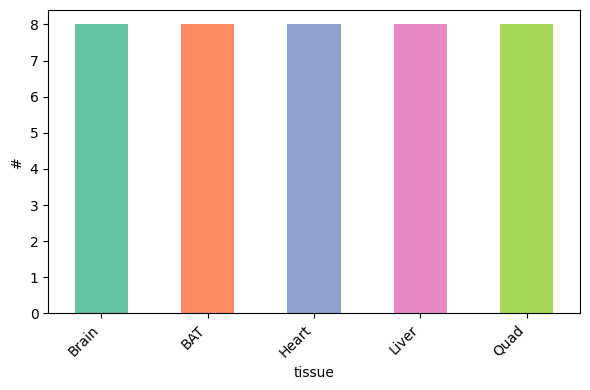

In [7]:
pr.pl.n_samples_per_category(
        adata, 
        category_key='tissue',
        order=tissue_order,
        color_scheme=adata.uns['colors_tissue']
        )

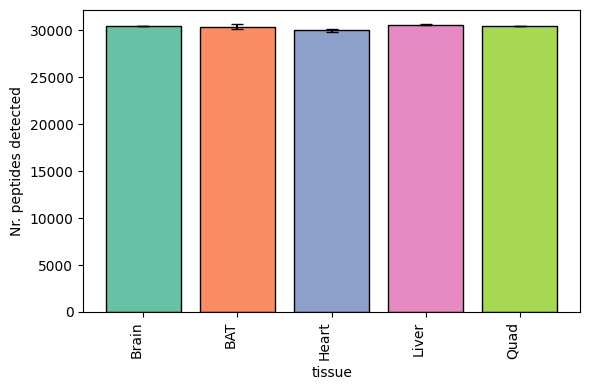

In [8]:
pr.pl.n_peptides_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns['colors_tissue'],
    )

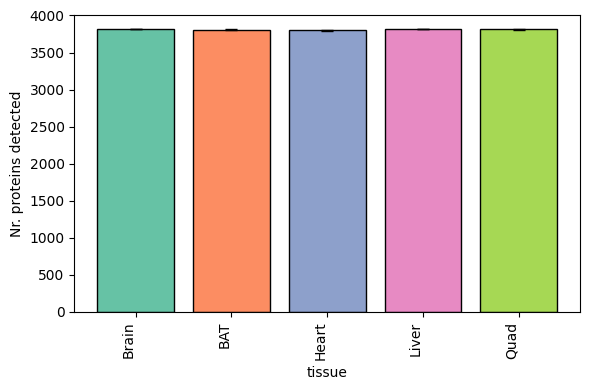

In [9]:
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns['colors_tissue'],
    )

In [10]:
pr.pp.extract_peptide_groups(adata, peptide_col="peptide_id")
pr.pp.summarize_overlapping_peptides(adata)

In [11]:
adata = adata[:,~adata.var['protein_id'].str.contains(';', na=False)]

In [12]:
check_proteodata(adata)

(True, 'peptide')

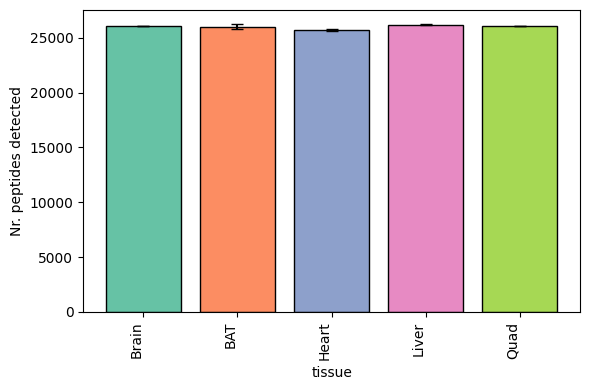

In [13]:
pr.pl.n_peptides_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns['colors_tissue'],
    )

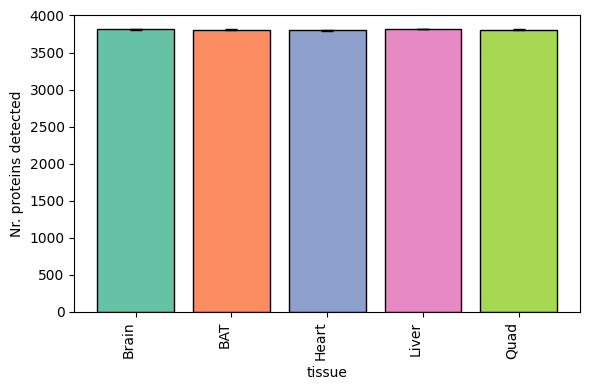

In [14]:
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns['colors_tissue'],
    )

In [15]:
pr.pp.filter_samples(adata, min_count=25000)

0 obs removed


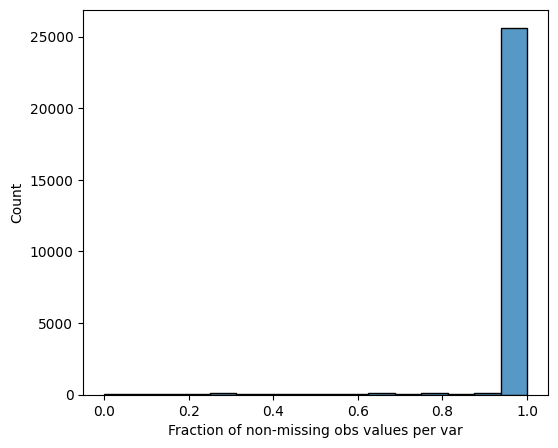

In [16]:
pr.pl.completeness_per_var(adata, zero_to_na=True)

In [17]:
pr.pp.filter_var_completeness(adata, min_fraction=1, group_by='tissue', zero_to_na=True)
# pr.pp.filter_var_completeness(adata, min_fraction=0.5, zero_to_na=True)

108 var removed


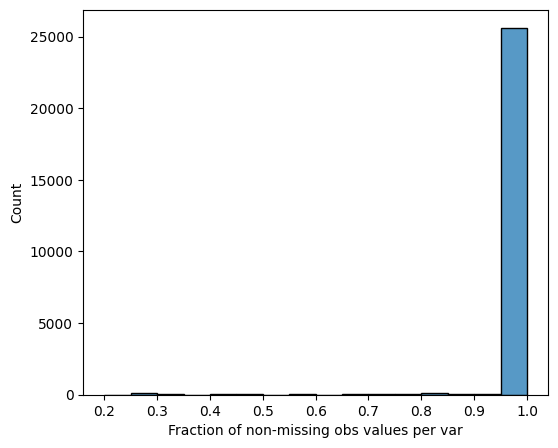

In [18]:
pr.pl.completeness_per_var(adata, zero_to_na=True)

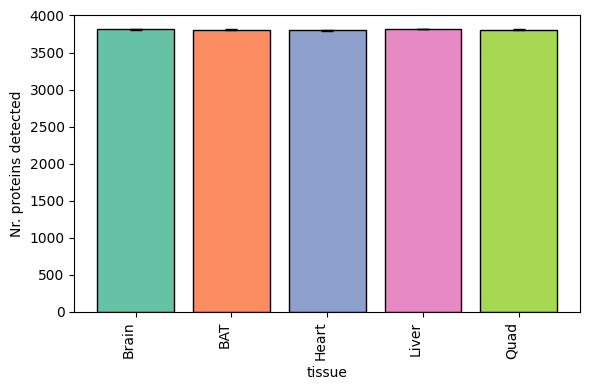

In [19]:
pr.pl.n_proteins_per_sample(
    adata,
    zero_to_na=True,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns['colors_tissue'],
    )

/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_
/home/ifichtner/repositories/proteopy/proteopy/pp/stats.py:172: RuntimeWarning: invalid value encountered in divide
  cv = std_ / mean_


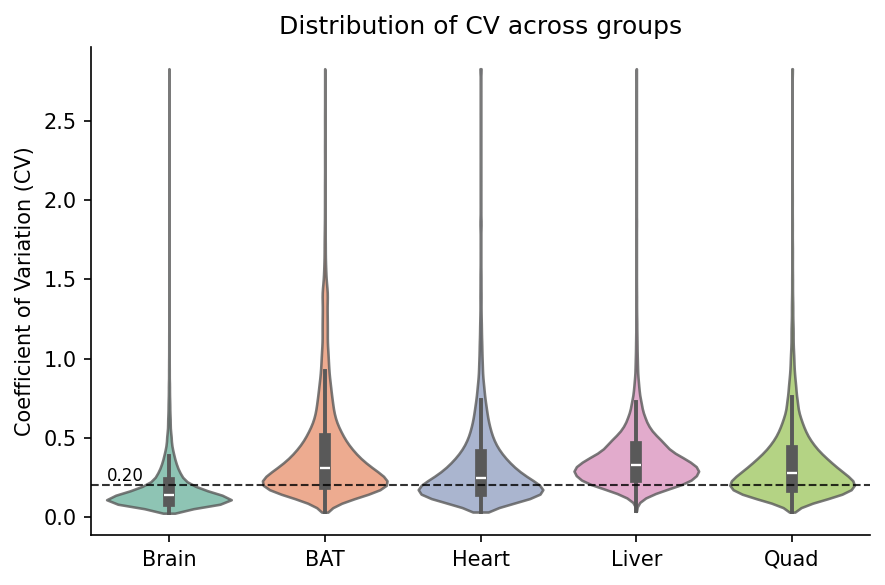

In [20]:
pr.pl.cv_by_group(
    adata,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns["colors_tissue"],
    figsize=(6, 4),
    hline=0.2,
    )

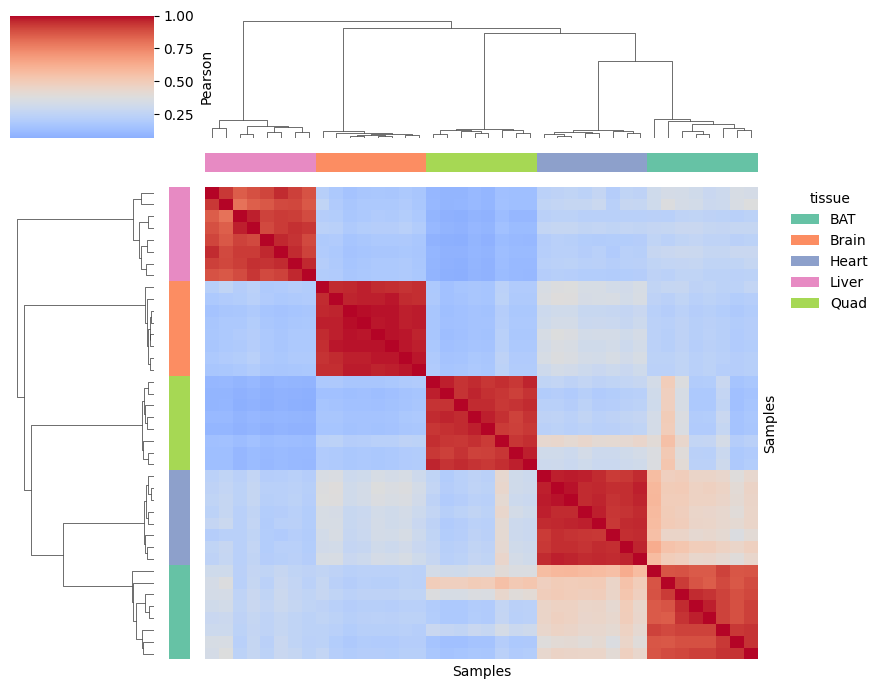

In [21]:
pr.pl.sample_correlation_matrix(
    adata,
    method="pearson",
    zero_to_na=True,
    margin_color="tissue",
    color_scheme=adata.uns["colors_tissue"],
    fill_na=0,
)

In [22]:
adata.X[adata.X == 0] = np.nan
adata.layers['raw'] = adata.X
adata.X = np.log2(adata.X)

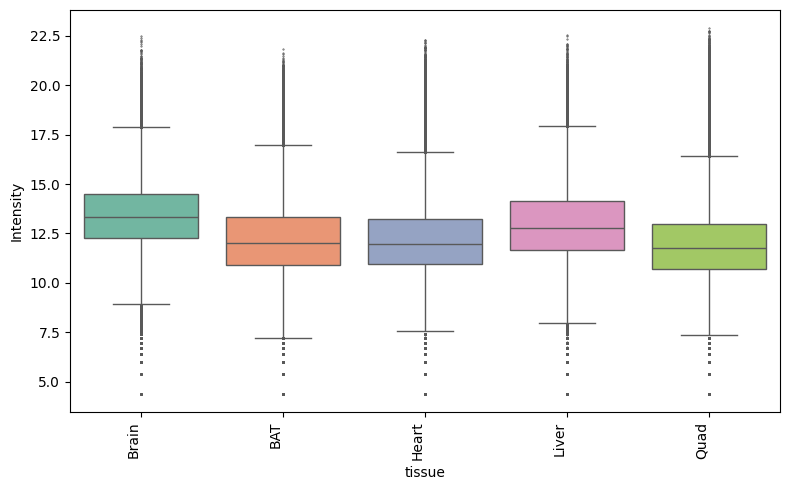

<Axes: xlabel='tissue', ylabel='Intensity'>

In [23]:
pr.pl.intensity_box_per_sample(
    adata,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns['colors_tissue'],
)

In [24]:
pr.pp.normalize_median(adata, method='median_ref', log_space=True)

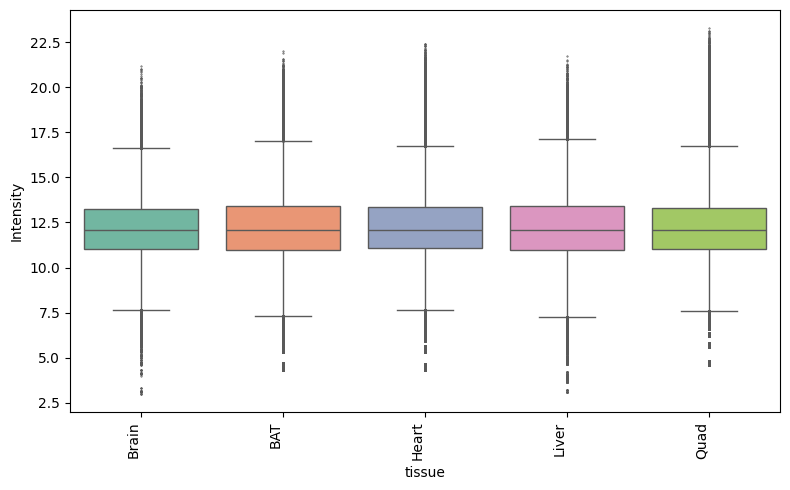

<Axes: xlabel='tissue', ylabel='Intensity'>

In [25]:
pr.pl.intensity_box_per_sample(
    adata,
    group_by='tissue',
    order=tissue_order,
    color_scheme=adata.uns['colors_tissue'],
)

In [26]:
pr.pp.impute_downshift(adata, width=0.3, downshift=1.8, random_state=123)

In [27]:
# Nr of measured and imputed values
mask = np.asarray(adata.layers["imputation_mask_X"], dtype=bool)
measured_n = int((~mask).sum())
imputed_n = int(mask.sum())
print(f"Measured: {measured_n:,} values ({100*measured_n/(measured_n+imputed_n):.1f}%)")
print(f"Imputed: {imputed_n:,} values ({100*imputed_n/(measured_n+imputed_n):.1f}%)")

Measured: 1,040,193 values (99.1%)
Imputed: 8,927 values (0.9%)


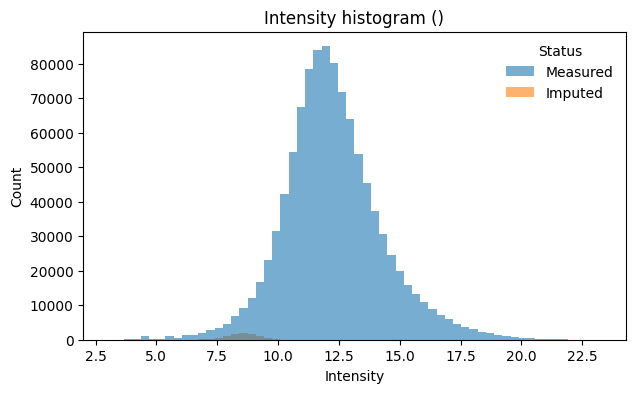

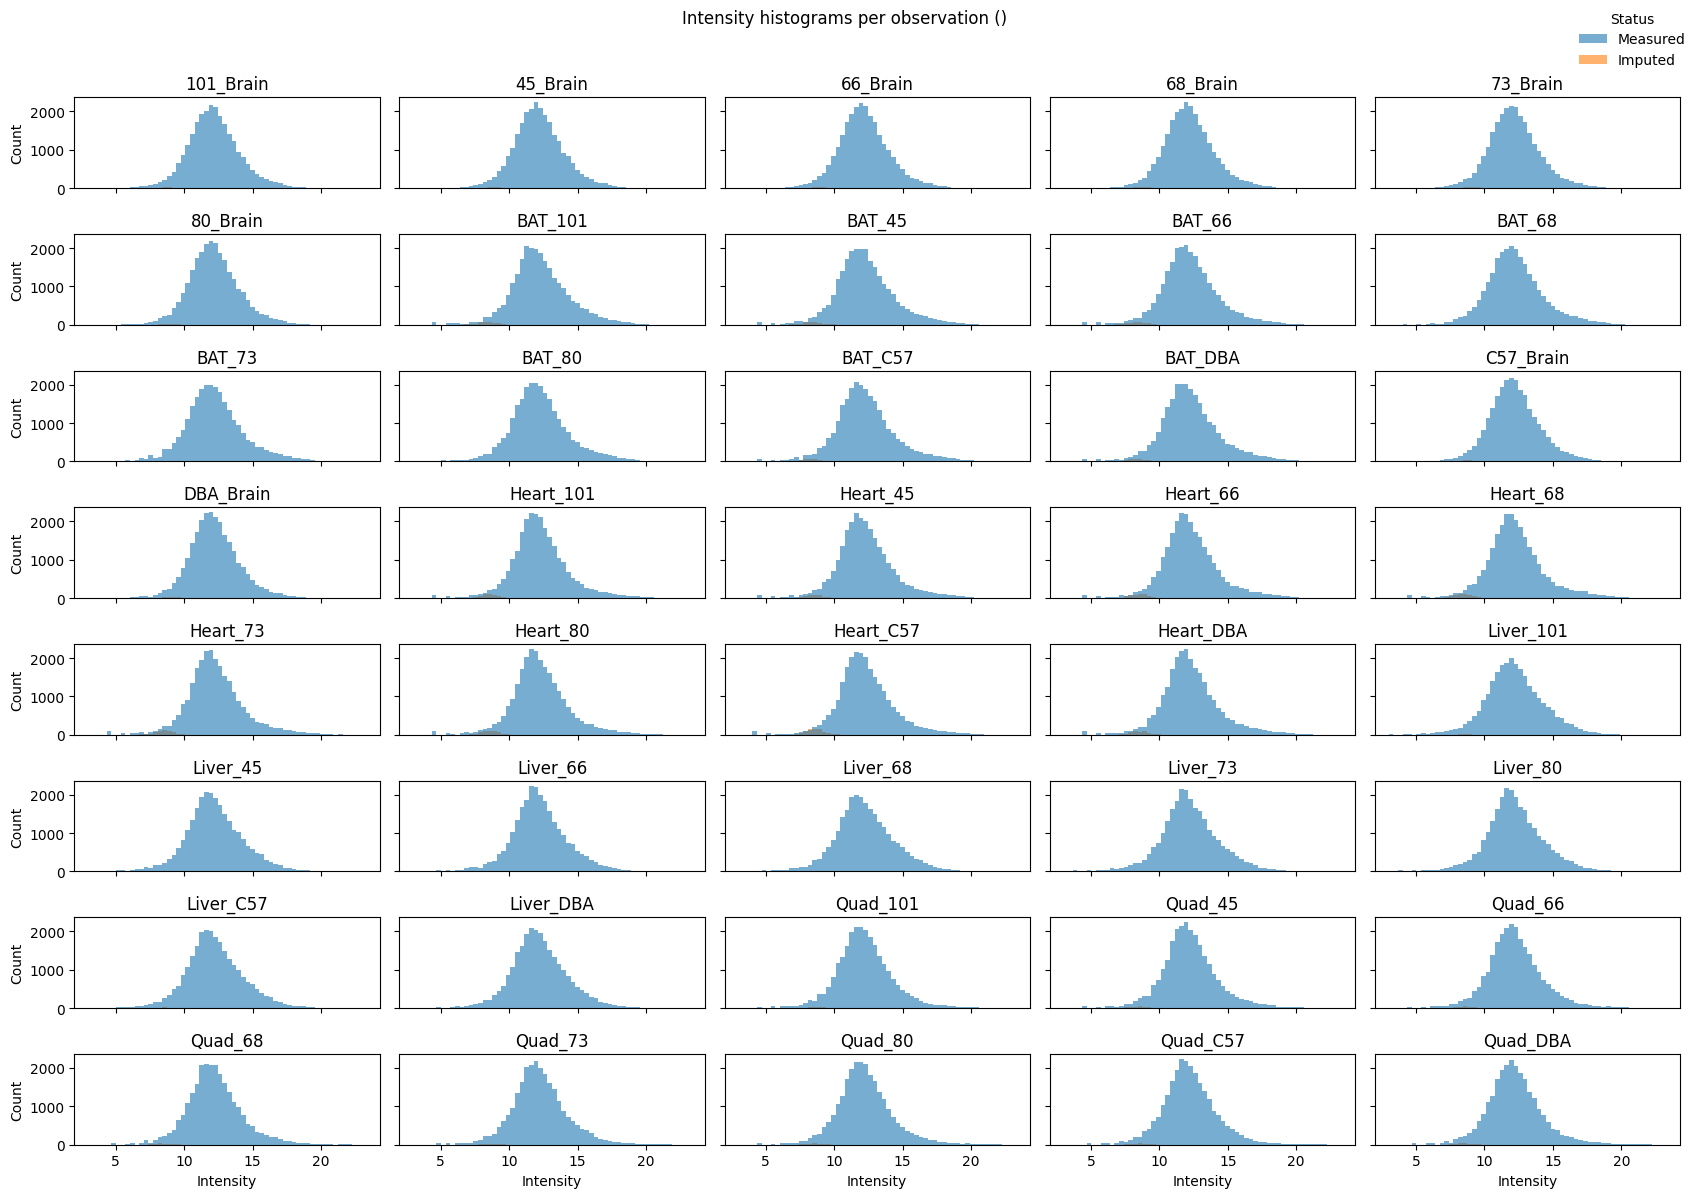

In [28]:
# Visualize intensity distribution with imputed values highlighted

# Combined histogram across all samples
pr.pl.intensity_hist(
    adata,
    color_imputed=True,  # Color imputed vs measured values differently
    density=False,
    )

# Per-sample histograms (small multiples)
pr.pl.intensity_hist(
    adata,
    color_imputed=True,
    per_obs=True,   # One subplot per sample
    ncols=5,
    legend_loc="upper right",
    density=False,
    figsize=(17, 12),
    )

In [29]:
adata.X[np.isnan(adata.X)] = 0

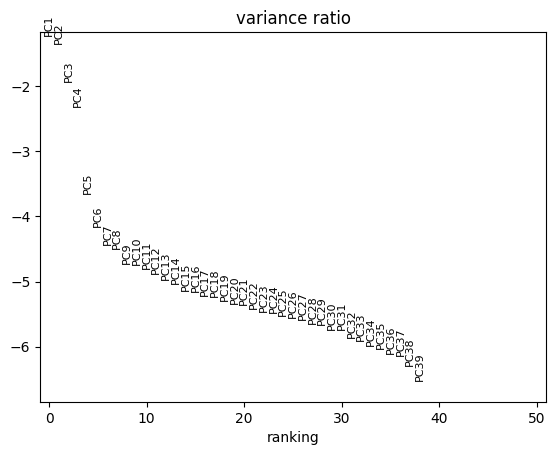

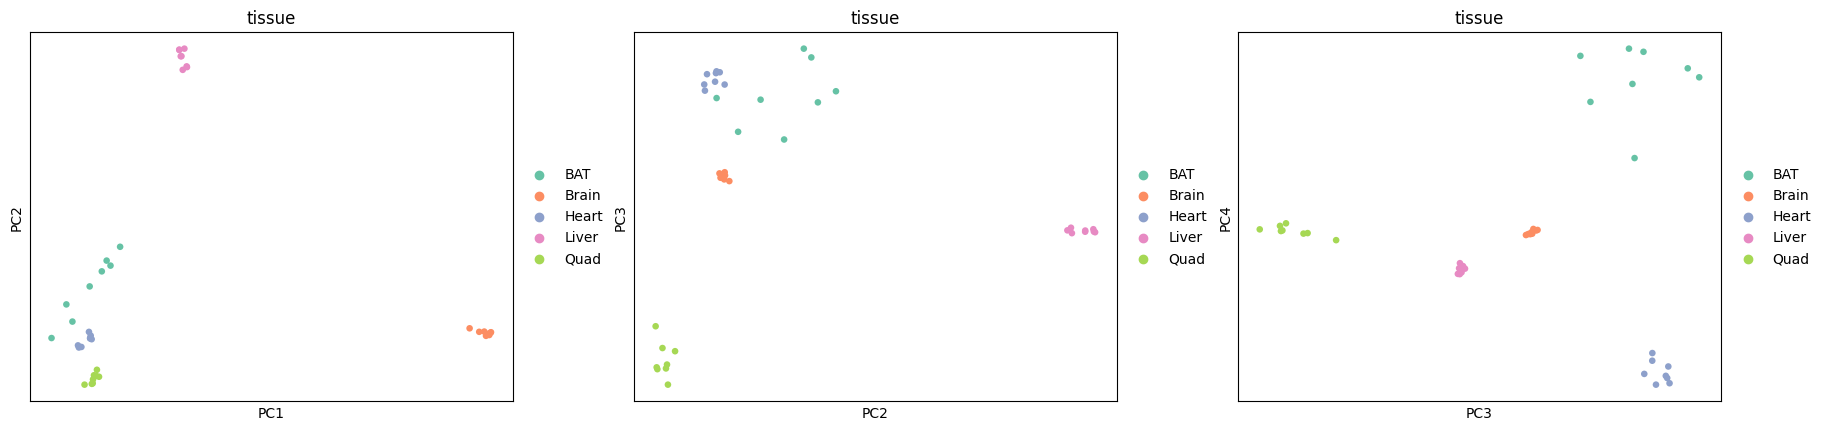

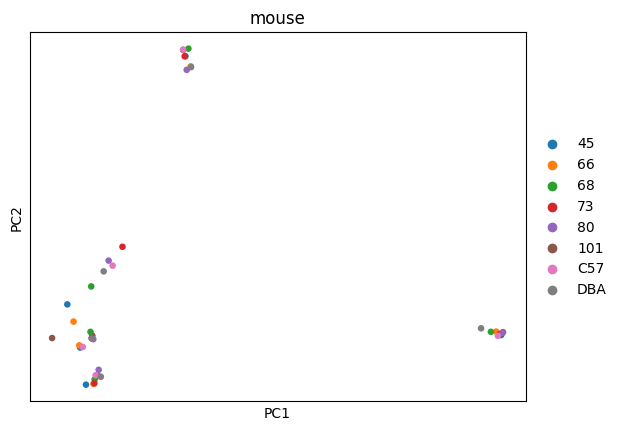

In [30]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pl.pca(
    adata,
    color=['tissue', 'tissue', 'tissue'],
    dimensions=[(0, 1), (1, 2), (2,3)],
    ncols=3,
    size=90,
    palette=adata.uns['colors_tissue'],
    )
sc.pl.pca(
    adata,
    color=['mouse'],
    dimensions=[(0, 1)],
    size=90,
    )


/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ifichtner/.local/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


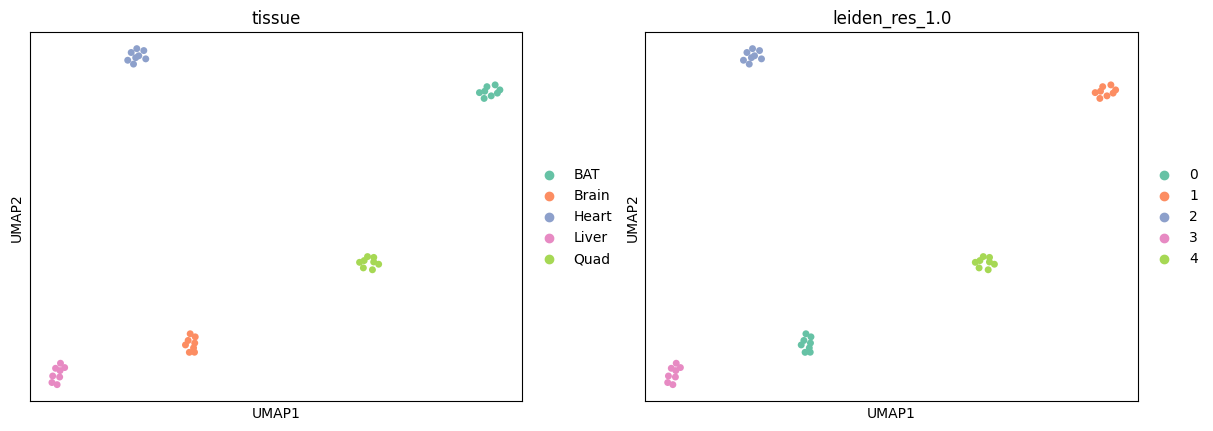

In [31]:
leiden_res = 1.0
leiden_key = f'leiden_res_{str(leiden_res)}'

sc.pp.neighbors(adata, n_neighbors=4)
sc.tl.leiden(
    adata,
    flavor='igraph',
    resolution=leiden_res,
    n_iterations=2,
    key_added=leiden_key,
    )
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=['tissue', leiden_key],
    size=100,
    palette=adata.uns['colors_tissue'],
    )

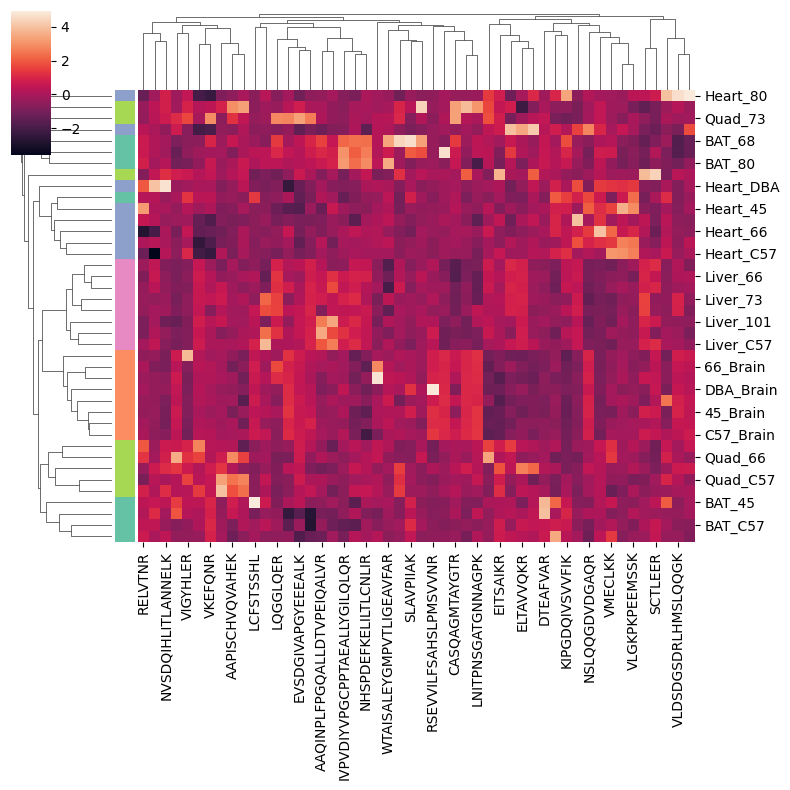

In [32]:
# 1) Mark the 500 most variable proteins (HVG-style)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=50,
    inplace=True
)

# 2) Get those variable features
adata_var = adata[:, adata.var['highly_variable']].copy()

# 3) Clustered heatmap (Scanpy style)
sc.pl.clustermap(
    adata_var,
    obs_keys='tissue',
    z_score=1,
    figsize=(8,8),
    dendrogram_ratio=0.15,
    show=True
)

In [33]:
adata.layers['imputed'] = adata.X
adata.X = adata.layers['raw']
adata.X[np.isnan(adata.X)] = 0

In [34]:
# pr.pl.box(
#     adata,
#     keys=adata.var_names[:3].to_list(),
#     group_by='tissue',
#     show_points=True,
#     point_size=7,
#     color_scheme=adata.uns['colors_tissue']
# )

In [35]:
pr.pp.filter_proteins_by_peptide_count(adata, min_count=5)
pr.pp.remove_zero_variance_vars(adata)

Removed 2082 proteins and 4234 peptides.
Removed 0 variables.


In [36]:
pr.tl.pairwise_peptide_correlations(adata)
pr.tl.peptide_dendograms_by_correlation(adata, method='agglomerative-hierarchical-clustering')
pr.tl.peptide_clusters_from_dendograms(adata, n_clusters=2, min_peptides_per_cluster=2)
pr.tl.proteoform_scores(adata, alpha=0.4)

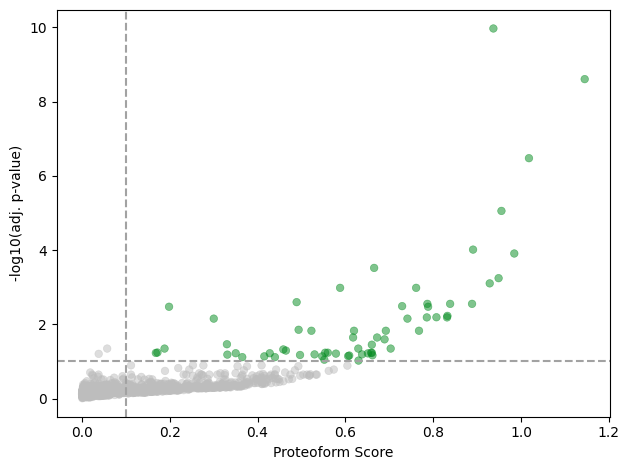

In [37]:
pr.pl.proteoform_scores(adata, adj=True, pval_threshold=0.1, score_threshold=0.1, log_scores=True)

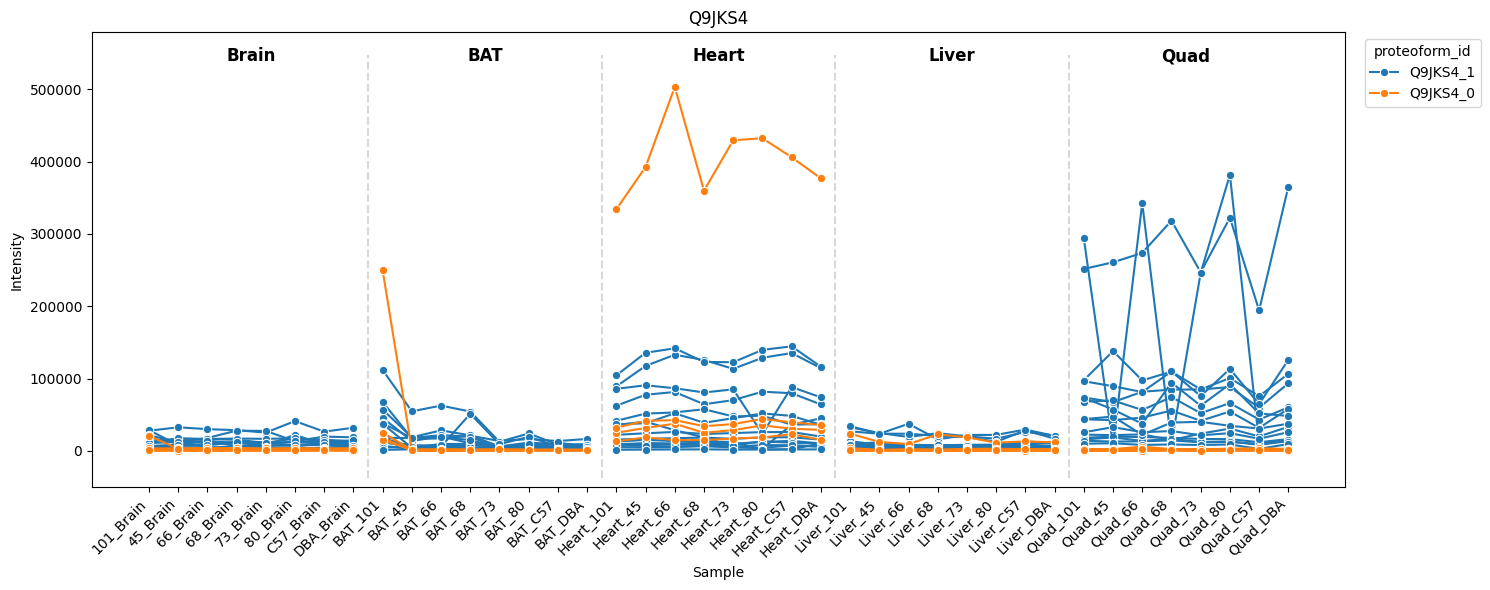

In [40]:
pr.pl.proteoform_intensities(
    adata,
    protein_ids="Q9JKS4",
    order_by='tissue',
    order=tissue_order,
    xlab_rotation=45,
    )

In [ ]:
pr.get.proteoforms_df(adata, proteins="Q9JKS4")

,protein_id,peptide_id,cluster_id,proteoform_score,proteoform_score_pval,proteoform_score_pval_adj,is_proteoform
0,Q9JKS4,ASSEGAQGSVSPK,0.0,0.529813,0.002771,0.064416,1.0
1,Q9JKS4,EMAQMYQMSLR,0.0,0.529813,0.002771,0.064416,1.0
2,Q9JKS4,QYNNPIGLYSAETLR,0.0,0.529813,0.002771,0.064416,1.0
3,Q9JKS4,VLPGPSQPR,0.0,0.529813,0.002771,0.064416,1.0
4,Q9JKS4,AAQSQLSQGDLVVAIDGVNTDTMTHLEAQNK,1.0,0.529813,0.002771,0.064416,1.0
5,Q9JKS4,ASGAGLLGGSLPVKDLAVDSASPVYQAVIK,1.0,0.529813,0.002771,0.064416,1.0
6,Q9JKS4,CYEQFFAPICAK,1.0,0.529813,0.002771,0.064416,1.0
7,Q9JKS4,GAPAYNPTGPQVTPLAR,1.0,0.529813,0.002771,0.064416,1.0
8,Q9JKS4,GPFLVAMGR,1.0,0.529813,0.002771,0.064416,1.0
9,Q9JKS4,ILAQMTGTEYMQDPDEEALRR,1.0,0.529813,0.002771,0.064416,1.0


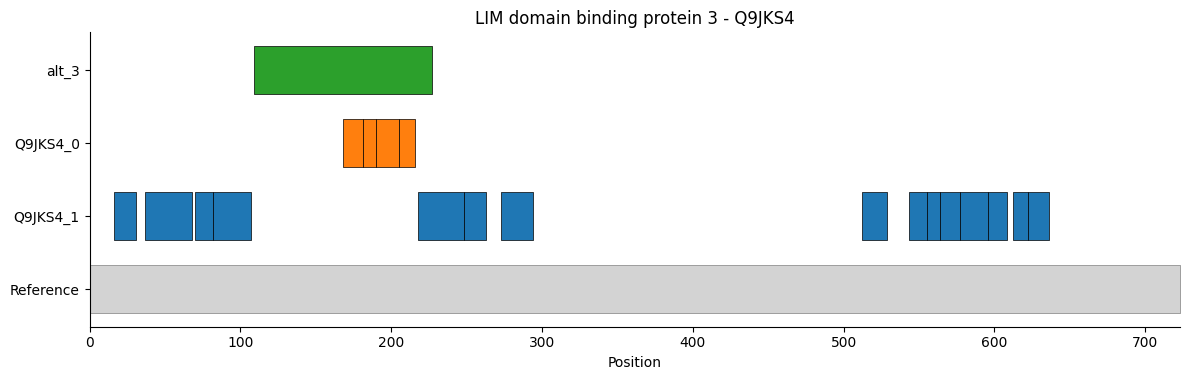

In [ ]:
seq = 'MSYSVTLTGPGPWGFRLQGGKDFNMPLTISRITPGSKAAQSQLSQGDLVVAIDGVNTDTMTHLEAQNKIKSASYNLSLTLQKSKRPIPISTTAPPIQSPLPVIPHQKDPALDTNGSLATPSPSPEARASPGALEFGDTFSSSFSQTSVCSPLMEASGPVLPLGSPVAKASSEGAQGSVSPKVLPGPSQPRQYNNPIGLYSAETLREMAQMYQMSLRGKASGAGLLGGSLPVKDLAVDSASPVYQAVIKTQSKPEDEADEWARRSSNLQSRSFRILAQMTGTEYMQDPDEEALRRSSTPIEHAPVCTSQATSPLLPASAQSPAAASPIAASPTLATAAATHAAAASAAGPAASPVENPRPQASAYSPAAAASPAPSAHTSYSEGPAAPAPKPRVVTTASIRPSVYQPVPASSYSPSPGANYSPTPYTPSPAPAYTPSPAPTYTPSPAPTYSPSPAPAYTPSPAPNYTPTPSAAYSGGPSESASRPPWVTDDSFSQKFAPGKSTTTVSKQTLPRGAPAYNPTGPQVTPLARGTFQRAERFPASSRTPLCGHCNNVIRGPFLVAMGRSWHPEEFNCAYCKTSLADVCFVEEQNNVYCERCYEQFFAPICAKCNTKIMGEVMHALRQTWHTTCFVCAACKKPFGNSLFHMEDGEPYCEKDYINLFSTKCHGCDFPVEAGDKFIEALGHTWHDTCFICAVCHVNLEGQPFYSKKDKPLCKKHAHAINV'
add_seqs = {
    'alt_3': {
        'seq_coord': (109, 227),
        'group': 'alt_3',
    }
}

pr.pl.peptides_on_sequence(
    adata,
    protein_id="Q9JKS4",
    group_by='proteoform_id',
    ref_sequence=seq,
    add_sequences=add_seqs,
    title="LIM domain binding protein 3 - Q9JKS4",
    )

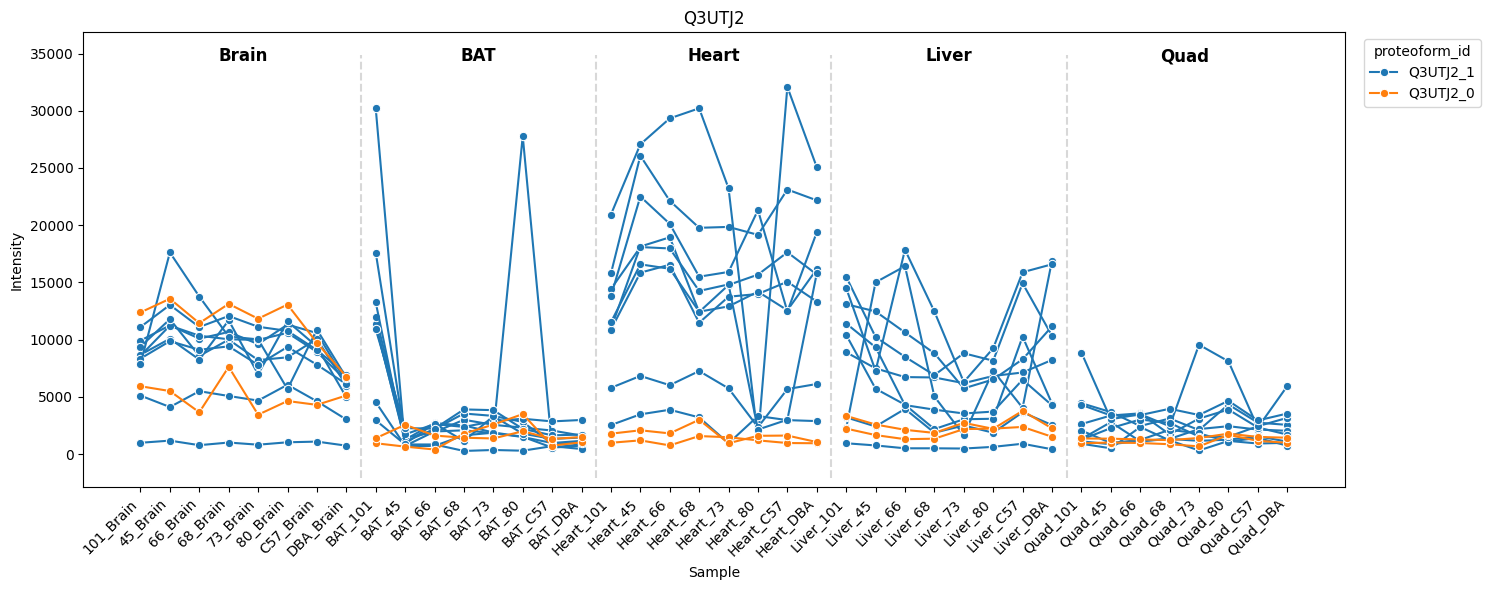

In [41]:
pr.pl.proteoform_intensities(
    adata,
    protein_ids="Q3UTJ2",
    order_by='tissue',
    order=tissue_order,
    xlab_rotation=45,
    )

In [ ]:
pr.get.proteoforms_df(adata, proteins="Q3UTJ2")

,protein_id,peptide_id,cluster_id,proteoform_score,proteoform_score_pval,proteoform_score_pval_adj,is_proteoform
0,Q3UTJ2,ASVVEALDSALKDICDQIK,0.0,0.619637,0.000343,0.014876,1.0
1,Q3UTJ2,LAFLVSPVPFR,0.0,0.619637,0.000343,0.014876,1.0
2,Q3UTJ2,ADLPGSSSTFTK,1.0,0.619637,0.000343,0.014876,1.0
3,Q3UTJ2,APHYPGIGPVDESGIPTAIR,1.0,0.619637,0.000343,0.014876,1.0
4,Q3UTJ2,AQPARPPPPVQPGEIGEAIAK,1.0,0.619637,0.000343,0.014876,1.0
5,Q3UTJ2,GLGDQSSSR,1.0,0.619637,0.000343,0.014876,1.0
6,Q3UTJ2,QGIFPVSYVEVVKR,1.0,0.619637,0.000343,0.014876,1.0
7,Q3UTJ2,SFISSSPSSPSR,1.0,0.619637,0.000343,0.014876,1.0
8,Q3UTJ2,SIFEYEPGK,1.0,0.619637,0.000343,0.014876,1.0
9,Q3UTJ2,SYSSTLTDLGR,1.0,0.619637,0.000343,0.014876,1.0


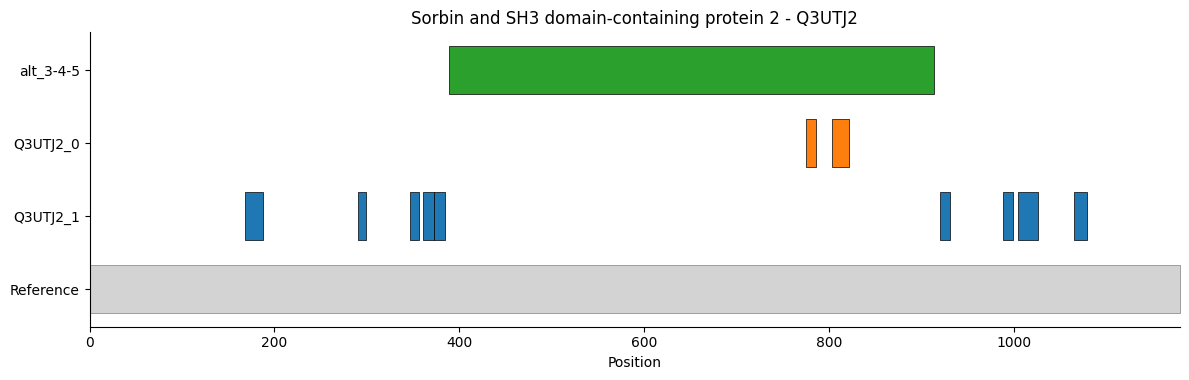

In [58]:
seq = 'MNTDSGGCARKRAAMSVTLTSVKRVQSSPNLLAAGRESQSPDSAWRSYNDRNPETLNGDATYSSLAAKGFRSVRPNLQDKRSPTQSQITINGNSGGAVSPVSYYQRPFSPSAYSLPASLNSSIIMQHGRSLDSAETYSQHAQSLDGTMGSSIPLYRSSEEEKRVTVIKAPHYPGIGPVDESGIPTAIRTTVDRPKDWYKTMFKQIHMVHKPGLYNSPYSAQSHPAAKTQTYRPLSKSHSDNGTDAFKEVPSPVPPPHVPPRPRDQSSTLKHDWDPPDRKVDTRKFRSEPRSIFEYEPGKSSILQHERPVSIYQSSIDRSLERPSSSASMAGDFRKRRKSEPAVGPLRGLGDQSSSRTSPGRADLPGSSSTFTKSFISSSPSSPSRAQGGDDSKMCPPLCSYSGLNGTPSGELECCNAYRQHLDVPGDSQRAITFKNGWQMARQNAEIWSSTEETVSPKIKSRSCDDLLNDDCDSFPDPKTKSESMGSLLCEEDSKESCPMTWASPYIQEVCGNSRSRLKHRSAHNAPGFLKMYKKMHRINRKDLMNSEVICSVKSRILQYEKEQQHRGLLHGWSQSSTEEVPRDVVPTRISEFEKLIQKSKSMPNLGDEMLSPITLEPPQNGLCPKRRFSIESLLEEETQVRHPSQGQRSCKSNTLVPIHIEVTSDEQPRTHMEFSDSDQDGVVSDHSDYVHVEGSSFCSESDFDHFSFTSSESFYGSSHHHHHHHHHHRHLISSCKGRCPASYTRFTTMLKHERAKHENMDRPRRQEMDPGLSKLAFLVSPVPFRRKKILTPQKQTEKAKCKASVVEALDSALKDICDQIKAEKRRGSLPDNSILHRLISELLPQIPERNSSLHALKRSPMHQPFHPLPPDGASHCPLYQNDCGRMPHSASFPDVDTTSNYHAQDYGSALSLQDHESPRSYSSTLTDLGRSASRERRGTPEKEKLPAKAVYDFKAQTSKELSFKKGDTVYILRKIDQNWYEGEHHGRVGIFPISYVEKLTPPEKAQPARPPPPVQPGEIGEAIAKYNFNADTNVELSLRKGDRIILLKRVDQNWYEGKIPGTNRQGIFPVSYVEVVKRNAKGAEDYPDPPLPHSYSSDRIYTLSSNKPQRPGFSHENIQGGGEPFQALYNYTPRNEDELELRESDVVDVMEKCDDGWFVGTSRRTKFFGTFPGNYVKRL'
add_seqs = {
    'alt_3-4-5': {
        'seq_coord': (389, 914),
        'group': 'alt_3-4-5',
    }
}

pr.pl.peptides_on_sequence(
    adata,
    protein_id="Q3UTJ2",
    group_by='proteoform_id',
    ref_sequence=seq,
    add_sequences=add_seqs,
    title="Sorbin and SH3 domain-containing protein 2 - Q3UTJ2",
    )

### @TODO: Proteoform quantification
For the ANOVA analysis, we selected proteoforms based on a proteoform score cutoff of 0.1 and adj. p-value threshold of 0.1. Outlier peptides from the clustering were removed prior to proteoform quantification, which was performed by proteinQuantification (quantLevel = “proteoform_id”, topN = 1000, keep_less = TRUE).

In [47]:
adata_prot = pr.tl.quantify_by_var(
    adata,
    group_by = "protein_id", 
    inplace = False,
)

AttributeError: module 'proteopy.tl' has no attribute 'quantify_by_var'

In [ ]:
adata_prot.var

In [ ]:
pr.pl.n_detected_proteins_per_sample(
    adata_prot,
    zero_to_na=True,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    xlabel_rotation=10,
    group_by_label_rotation=10
    )

In [ ]:
pr.pl.peptide_intensities(
    adata_prot,
    "Q9JKS4",
    group_by='tissue',
    xlab_rotation=45,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

In [ ]:
adata_proteoform = pr.tl.quantify_by_var(
    adata,
    group_by = "proteoform_id",
    inplace = False,
)

In [ ]:
adata_proteoform.var

In [ ]:
pr.pl.n_detected_proteins_per_sample(
    adata_proteoform,
    zero_to_na=True,
    group_by='tissue',
    color_scheme=adata.uns['colors_tissue'],
    xlabel_rotation=10,
    group_by_label_rotation=10
    )

In [ ]:
adata_proteoform.var

In [ ]:
pr.pl.peptide_intensities(
    adata_proteoform,
    "Q9JKS4",
    group_by='tissue',
    xlab_rotation=45,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

In [ ]:
pr.pl.peptide_intensities(
    adata_proteoform,
    "Q3UTJ2",
    group_by='tissue',
    xlab_rotation=45,
    show_zeros=False,
    group_by_label_rotation=30,
    figsize=(25,10),
)

# @ToDo: Differential analysis!